In [1]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
import keras.backend as K

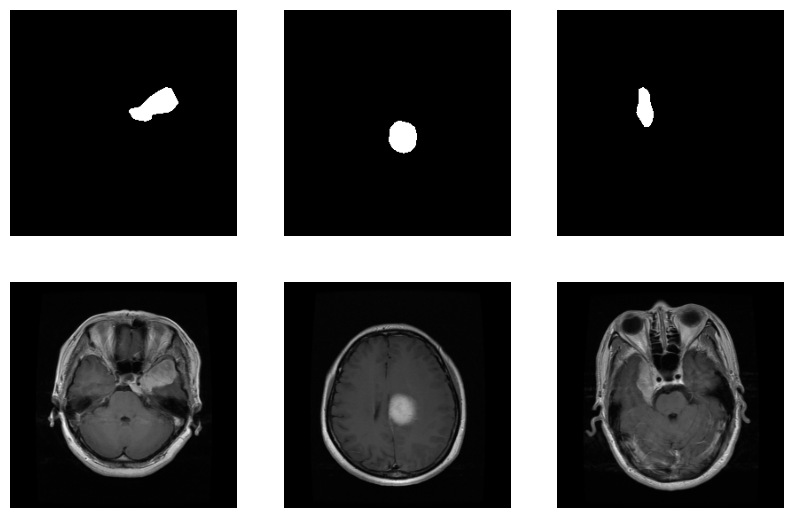

IMAGES:
Unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

In [2]:
SIZE_X = 256
SIZE_Y = 256
TRAIN_PATH = '/kaggle/input/brain-tumor-segmentation'

images = []

for directory_path in sorted(glob.glob(TRAIN_PATH + '/images/')):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.uint8) 
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.merge([img, img, img])
        images.append(img)    

images = np.array(images)

masks = [] 
for directory_path in sorted(glob.glob(TRAIN_PATH + '/masks/')):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)   
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
        mask = mask / 255
        mask = mask.astype(np.uint8)
        masks.append(mask)
                 
masks = np.array(masks)

n_samples = 3
plt.figure(figsize = (10, 10))
for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(masks[i], cmap = 'gray')
for i in range(n_samples):
    plt.subplot(n_samples, n_samples, 1 + n_samples + i)
    plt.axis('off')
    plt.imshow(images[i], cmap = 'gray')
plt.show()

print(f'IMAGES:\n'
f'Unique values: {np.unique(images)}\n'
f'Shape: {images.shape}\n'
f'Type: {images.dtype}\n\n'
f'MASKS:\n'
f'Unique values: {np.unique(masks)}\n'
f'Shape: {masks.shape}\n'
f'Type: {masks.dtype}')

In [3]:
y = np.expand_dims(masks, axis = 3)
print(y.shape)

(3064, 256, 256, 1)


In [4]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = masks.shape
train_masks_reshaped = masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(train_masks_encoded_original_shape))
print(train_masks_encoded_original_shape.shape)

[0 1]
(3064, 256, 256)


In [5]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis = 3)
print(train_masks_input.shape)

(3064, 256, 256, 1)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, train_masks_input, 
                                                    test_size = 0.15, shuffle = True, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.2, random_state = 42) 

from tensorflow.keras.utils import to_categorical
n_classes = 2
train_masks_cat = to_categorical(y_train, num_classes = n_classes)
test_masks_cat = to_categorical(y_test, num_classes = n_classes)
val_masks_cat = to_categorical(y_val, num_classes = n_classes)

print(f'TRAIN SET:\n'
     f'X_train shape: {X_train.shape}\n'
     f'y_train shape: {train_masks_cat.shape}\n\n'
     f'VALIDATION SET:\n'
     f'X_val shape: {X_val.shape}\n'
     f'y_val shape: {val_masks_cat.shape}\n\n'
     f'TEST SET:\n'
     f'X_test shape: {X_test.shape}\n'
     f'y_test shape: {test_masks_cat.shape}')

TRAIN SET:
X_train shape: (2083, 256, 256, 3)
y_train shape: (2083, 256, 256, 2)

VALIDATION SET:
X_val shape: (521, 256, 256, 3)
y_val shape: (521, 256, 256, 2)

TEST SET:
X_test shape: (460, 256, 256, 3)
y_test shape: (460, 256, 256, 2)


In [7]:
def double_conv_block(x, n_filters):
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x


def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
   
    p = MaxPool2D(2)(f)
    return f, p


def upsample_block(x, conv_features, n_filters):
  
    x = Conv2DTranspose(n_filters, 3, 2, padding = "same")(x)
    
    x = concatenate([x, conv_features])
    x = double_conv_block(x, n_filters)
    return x

In [8]:
 LR = 0.0001 
optimizer = Adam(LR) 
activation = 'sigmoid' 
loss = 'binary_crossentropy' 

def dice_coef(y_true, y_pred, smooth = 1.0):
    class_num = 2 
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

metrics = [dice_coef, tf.keras.metrics.MeanIoU(num_classes = n_classes)]
img_size = (256, 256, 3) 

def build_unet_model(img_size, num_classes):
    inputs = Input(shape = img_size)
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = Conv2D(num_classes, 1, padding = "same", activation = activation)(u9)
    unet_model = tf.keras.Model(inputs, outputs, name = "U-Net")
    return unet_model

In [9]:
K.clear_session()

unet_model = build_unet_model(img_size, n_classes)

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

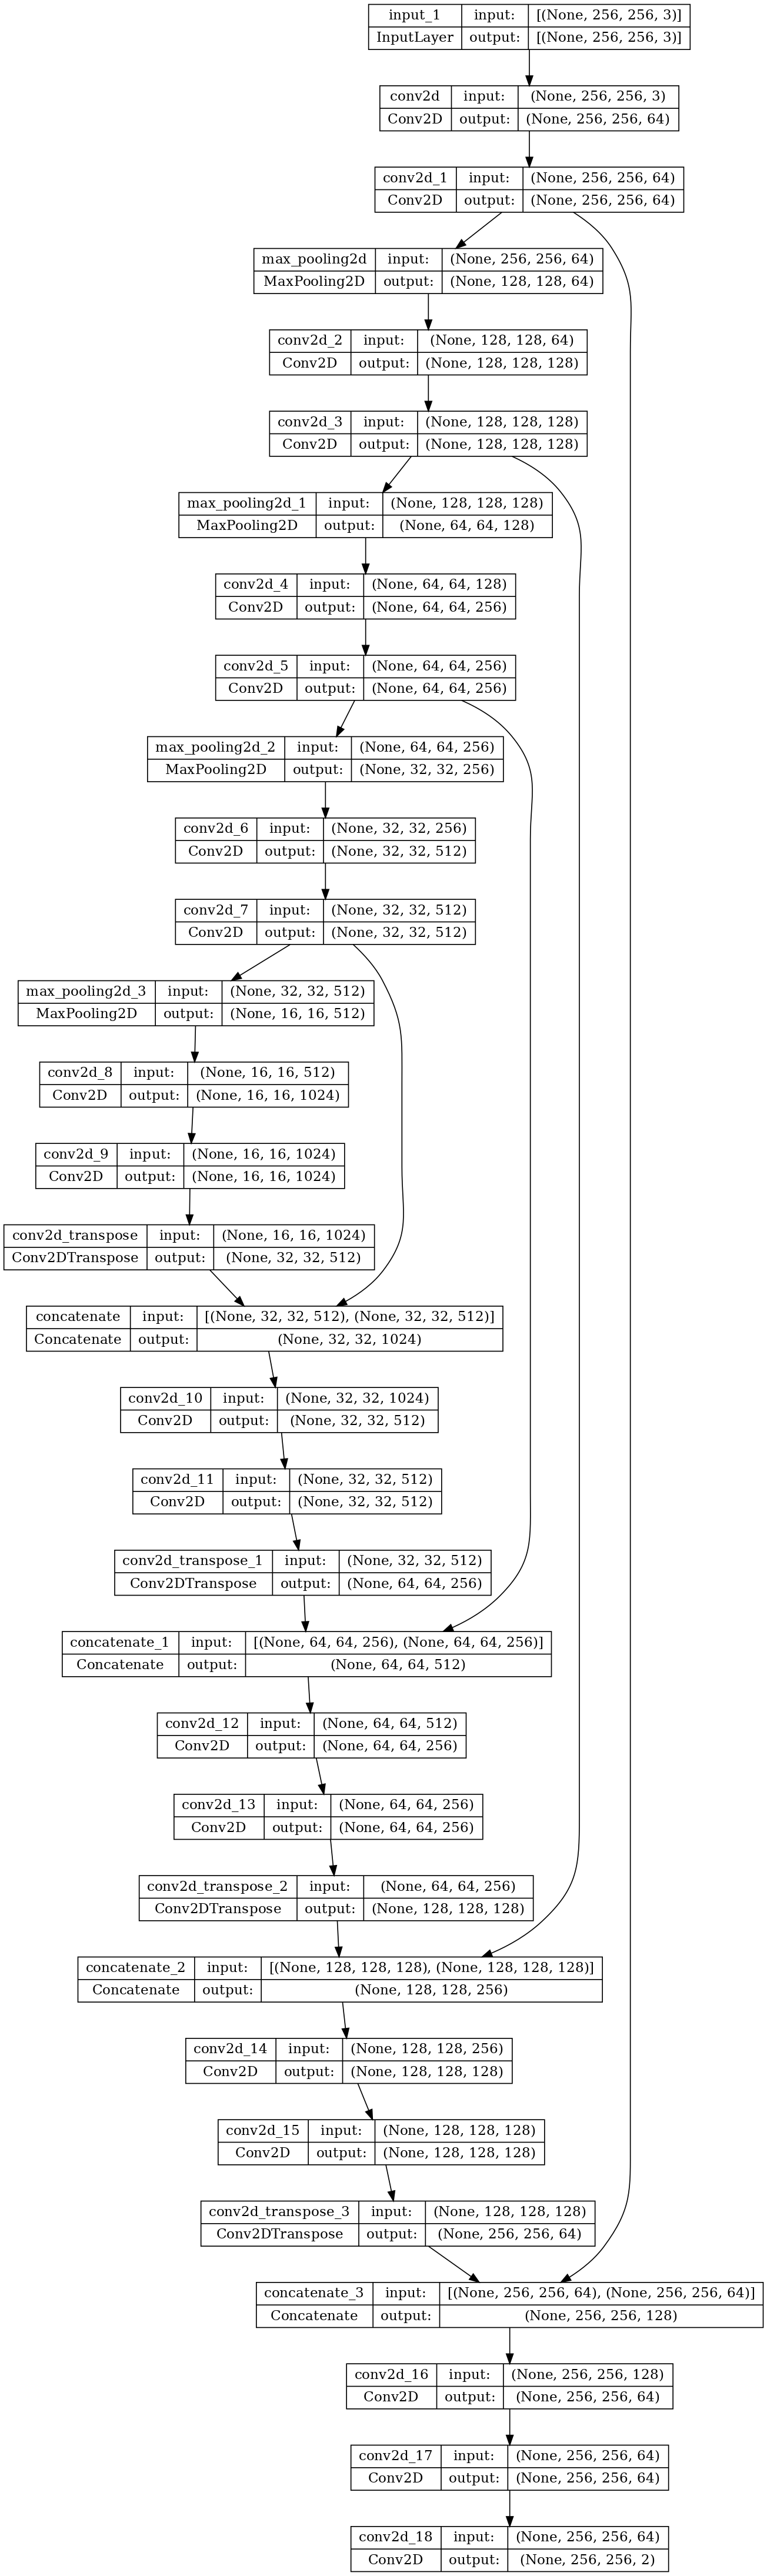

In [10]:
plot_model(unet_model, show_shapes = True, show_layer_names = True, dpi = 120)

In [11]:
unet_model.compile(optimizer = optimizer,
                  loss = loss,
                  metrics = metrics)

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

earlystopper = EarlyStopping(patience = 5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = '/kaggle/working/checkpoint.hdf5',
                               verbose = 1,
                               save_best_only = True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,
                              patience = 3, min_lr = 0.000001,
                              verbose = 1,  cooldown = 1)

history = unet_model.fit(X_train, train_masks_cat, batch_size = 10, epochs = 20, verbose = 1,
                        shuffle = True, callbacks = [earlystopper, checkpointer, reduce_lr],
                        validation_data = (X_val, val_masks_cat))

Epoch 1/20
209/209 [==============================] - ETA: 0s - loss: 0.4281 - dice_coef: 0.5164 - mean_io_u: 0.6328
Epoch 1: val_loss improved from inf to 0.09400, saving model to /kaggle/working/checkpoint.hdf5
209/209 [==============================] - 86s 323ms/step - loss: 0.4281 - dice_coef: 0.5164 - mean_io_u: 0.6328 - val_loss: 0.0940 - val_dice_coef: 0.5664 - val_mean_io_u: 0.6937 - lr: 1.0000e-04
Epoch 2/20
209/209 [==============================] - ETA: 0s - loss: 0.0755 - dice_coef: 0.6048 - mean_io_u: 0.6904
Epoch 2: val_loss improved from 0.09400 to 0.05740, saving model to /kaggle/working/checkpoint.hdf5
209/209 [==============================] - 64s 305ms/step - loss: 0.0755 - dice_coef: 0.6048 - mean_io_u: 0.6904 - val_loss: 0.0574 - val_dice_coef: 0.6754 - val_mean_io_u: 0.7029 - lr: 1.0000e-04
Epoch 3/20
209/209 [==============================] - ETA: 0s - loss: 0.0572 - dice_coef: 0.6676 - mean_io_u: 0.6877
Epoch 3: val_loss improved from 0.05740 to 0.05142, saving 

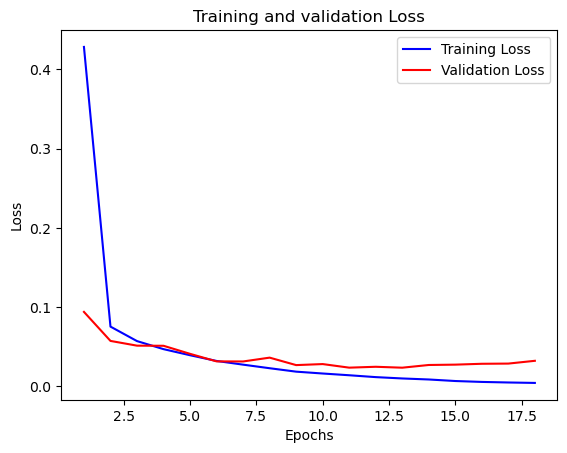

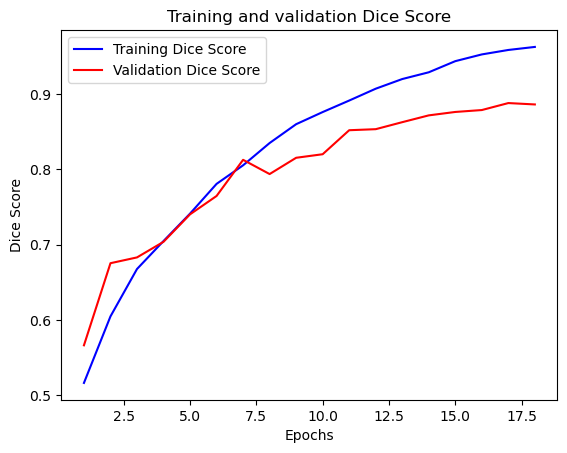

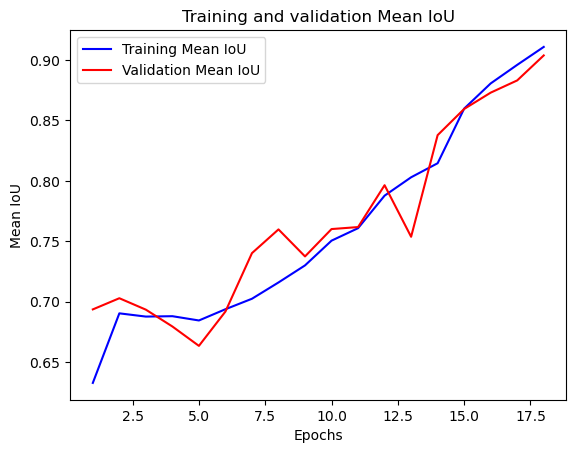

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']

plt.plot(epochs, dice, 'b', label='Training Dice Score')
plt.plot(epochs, val_dice, 'r', label='Validation Dice Score')
plt.title('Training and validation Dice Score')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

m_iou = history.history['mean_io_u']
val_m_iou = history.history['val_mean_io_u']

plt.plot(epochs, m_iou, 'b', label='Training Mean IoU')
plt.plot(epochs, val_m_iou, 'r', label='Validation Mean IoU')
plt.title('Training and validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

In [14]:
unet_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
print("Evaluate on test data")
results = unet_model.evaluate(X_test, test_masks_cat, batch_size = 10)

Evaluate on test data
46/46 [==============================] - 5s 96ms/step - loss: 0.0306 - dice_coef: 0.8942 - mean_io_u: 0.9067


1/1 [==============================] - 0s 291ms/step


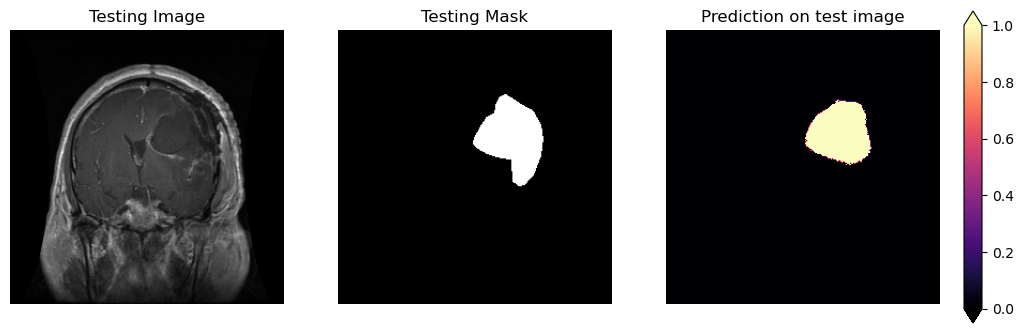

In [15]:
from random import randint

test_img_number = randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
test_mask = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
test_pred1 = unet_model.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 8), ncols = 3)
ax1.set_title('Testing Image')
ax1.axis('off')
ax1.imshow(test_img[:, :, 0], cmap = 'gray')
ax2.set_title('Testing Mask')
ax2.axis('off')
ax2.imshow(test_mask[:, :, 0], cmap = 'gray')
ax3.set_title('Prediction on test image')
ax3.axis('off')
pred = ax3.imshow(test_prediction1, cmap = 'magma')
fig.colorbar(pred, cax = fig.add_axes([0.92, 0.3, 0.015, 0.39]), extend='both')
plt.show()